#Short-Term Stock Price-Trend Prediction Using Meta-Learning

This notebook contains an adaptation of the *sliding time horizon* stocks labelling method proposed in `chang2021short`, referred to as "Slope detection labelling", originally designed for a meta-learning framework based on stock price dataset and other techincal indicators such as ATR, EMA20, MACD, ROC, ...

The ultimate goal was to develop a similar labeling method based on LOB datasets features, in particular the *mid-prices*.

For this purpose, I used the normalized midprices contained in FI-2020 dataset proposed in `ntakaris2018benchmark`.

```
@inproceedings{chang2021short,
  title={Short-Term Stock Price-Trend Prediction Using Meta-Learning},
  author={Chang, Shin-Hung and Hsu, Cheng-Wen and Li, Hsing-Ying and Zeng, Wei-Sheng and Ho, Jan-Ming},
  booktitle={2021 IEEE International Conference on Systems, Man, and Cybernetics (SMC)},
  pages={2900--2905},
  year={2021},
  organization={IEEE}
}
```



```
@article{ntakaris2018benchmark,
  title={Benchmark dataset for mid-price forecasting of limit order book data with machine learning methods},
  author={Ntakaris, Adamantios and Magris, Martin and Kanniainen, Juho and Gabbouj, Moncef and Iosifidis, Alexandros},
  journal={Journal of Forecasting},
  volume={37},
  number={8},
  pages={852--866},
  year={2018},
  publisher={Wiley Online Library}
}
```





This method was emplyed to define stock price trends known as: *rise+*, *rise* and *fall+*, *fall*.


Consider the following metrics be computed on the same stock *n*, let:

* $p_d$: closing price at day *d*
* $F_d = \sum_{i=1}^K p_{d+i}$: the average closing price in the next *K* days
* $B_d = \sum_{i=0}^{K+1} p_{d-i}$: the average closing price in the previous *K* days
* $\delta_d = F_d - B_d$: the *slope*
* $\mu_d$: the mean value of closing price
* $\sigma_d$: the standard deviation of the stock during the *2K* days, compute according to the following expression:

$$ \sigma_d = \sqrt{\frac{\overset{K}{\underset{i=-K+1}{\sum}}(p_{d+i}-\mu_d)^2}{2K}} $$

$\sigma_d$ is then applied as a threshold against the closing price, as follow:

$$l(p_d) = \begin{cases}
    rise+,& \text{if } p_d \gt (\mu_d + \sigma_d) \,\text{ and }\ \delta_d \gt 0\\
    rise,& \text{if } \text{only } \delta_d \gt 0  \text{ holds}\\
    fall+,& \text{if } p_d \lt (\mu_d - \sigma_d) \,\text{ and }\ \delta_d \lt 0\\ 
    fall,& \text{if } \text{only } \delta_d \lt 0  \text{ holds}\\
\end{cases}$$ 

\\

The $+$ sign must be read as "peak" or "trough", accordingly if it referred to *rise* or *fall*.\
*i.e.*: "*rise+*" mean that the stock has reach its maximum value and from that point it will decrease; viceversa, "*fall+*" means that from that point, the trend will raise

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
from typing import Any, Dict, Optional, Tuple
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

## 🦞 Data download and exploration

**Dataset info**:
+ We used *no auction dataset* that is normalised by *decimal precision approach* 
+ The 'x_data' is a 2d-array that contains, for each row a snapshot of the orderbook in the following structure: 'best-ask price', 'best-ask volume', 'best-bid price', 'best-bid volume', '2-lev ask price', '2-levl ask volume', '2-lev bid price', '2-lev bid volume', ...
+ The first 7 days are used as training data and the remaining 3 days are used for testing
+ The training data are divided again with the 80/20 ratio in Training and Validation sets

In [3]:
datafolder = "/content/drive/MyDrive/Colab Notebooks/AI4T/CNN Trading Agent/Data/"

# data_file paths
train_file = "train.txt"
val_file = "val.txt"
test_file = "test.txt"

# prepare the new paths
new_train_file = "new_train.txt"
new_val_file = "new_val.txt"
new_test_file = "new_test.txt"


if not all(
    os.path.isfile(path) for path in [datafolder+train_file, datafolder+val_file, datafolder+test_file]
):
  # data paths
  train_paths = datafolder+"Train_Dst_NoAuction_DecPre_CF_7.txt"
  
  test_paths = [
                datafolder+"Test_Dst_NoAuction_DecPre_CF_7.txt",
                datafolder+"Test_Dst_NoAuction_DecPre_CF_8.txt",
                datafolder+"Test_Dst_NoAuction_DecPre_CF_9.txt",
  ]

  if not all(
    os.path.isfile(path) for path in [train_paths] + test_paths
             ):
    !wget "https://raw.githubusercontent.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books/master/data/data.zip -P datafolder
    !unzip -n datafolder+"data.zip" - d datafolder
  
  # load train + val data
  train_val_data = np.loadtxt(train_paths, unpack=True)

  # split into train and validation
  train_slice = slice(0, int(0.8 * train_val_data.shape[0]))
  val_slice = slice(int(0.8 * train_val_data.shape[0]), train_val_data.shape[0])

  train_data = train_val_data[train_slice,:]
  val_data = train_val_data[val_slice,:]

  # load test data
  test_data = np.concatenate([np.loadtxt(path, unpack=True) for path in test_paths])

  # save train, val, test data to file
  np.savetxt(datafolder + train_file, train_data)
  np.savetxt(datafolder + val_file, val_data)
  np.savetxt(datafolder + test_file, test_data)


# load train, val, test data
train_data = np.loadtxt(datafolder + train_file, unpack=False)
val_data = np.loadtxt(datafolder + val_file, unpack=False)
test_data = np.loadtxt(datafolder + test_file, unpack=False)

In [ ]:
train_data.shape, val_data.shape, test_data.shape

((203800, 149), (50950, 149), (139587, 149))

In [4]:
train_val_data = np.concatenate((train_data, val_data), axis=0) # Consider both train and val data as one
train_data_copy = train_val_data.copy()

train_input_data = train_data_copy[:,:40] # take the features
train_labels = train_data_copy[:,-5:] # take the labels

train_input_data.shape, train_labels.shape

((254750, 40), (254750, 5))

## 🪡🧵 Adapting the Method 

### 1. compute the *mid-prices* over all the timestamps

In [5]:
def compute_mid_prices(lob_data):
  lob_data_copy = lob_data.copy()
  mid_prices = (lob_data_copy[:,0] + lob_data_copy[:,2])/2
  return mid_prices 

In [6]:
mid_prices = compute_mid_prices(train_input_data)
mid_prices.shape
# compute the mean over all the mid-prices (probably is over the windows instead, but for now do it this way)
#m_d = mid_prices.mean()

(254750,)

###2. compute the *mid-prices* means within each time window

Future mean ($F_d$)

In [7]:
def future_avg_mid_prices(mid_prices, window_shape=3):
  """computes the avg mid-prices of a stock in the next K timeslots"""


  K = window_shape
  F_d = np.lib.stride_tricks.sliding_window_view(mid_prices, window_shape=K) # F_d.shape = (203797, 3), i.e.: n - (K-1)
  F_d = F_d[1:,:] # F_d.shape = (203797, 3) # for each timestamp, we consider the slide_view starting from the very next slot
  F_d = F_d.mean(axis=1) # here I normalize, while the paper does not
  F_d = F_d[K-1:] # we cutoff the first K-1 elements since for those we cannot compute the average mid-price of past K days -> we must have matching pairs 
  
  return F_d

Past mean ($B_d$)

In [8]:
def past_avg_mid_prices(mid_prices, window_shape=3):
  """computes the avg mid-prices of a stock per each slot in the past K timeslots, including that slot"""

  K = window_shape
  B_d = np.lib.stride_tricks.sliding_window_view(mid_prices[::-1], window_shape=K)
  B_d = B_d.mean(axis=1) # here I normalize, while the paper does not
  B_d = B_d[K:]
  B_d = B_d[::-1]

  return B_d

Overall mean ($μ_d$)

In [9]:
def compute_means(mid_prices, window_shape=3):
  """old version"""

  future_avg_mid_prices_vals = future_avg_mid_prices(mid_prices, window_shape=window_shape)
  past_avg_mid_prices_vals = past_avg_mid_prices(mid_prices, window_shape=window_shape)
  return (future_avg_mid_prices_vals + past_avg_mid_prices_vals) / 2

In [10]:
def compute_means(mid_prices, window_shape=3):
  """new version"""

  return past_avg_mid_prices(mid_prices, window_shape=window_shape)  

***nb***: if we have $n$ timestamps, we end up having the mid-prices averages only for: $n - (K-1) - (K)$ of those

###3. compute the slope

Slope $\delta_d$

In [11]:
def slope_d(future_avg_mid_prices, past_avg_mid_prices):
  return future_avg_mid_prices - past_avg_mid_prices

###4. compute the standard deviation for stock trend over 2K days

Standard deviation ($\sigma_d$)

In [12]:
def stock_std_dev(mid_prices, window_shape=3):
  """computes the standard deviation of a stock for each timeslot, during the 2K past/future timeslots"""
  
  K = window_shape

  means = np.expand_dims(compute_means(mid_prices, window_shape=K), axis=1)

  Fs_d = np.lib.stride_tricks.sliding_window_view(mid_prices, window_shape=K) # F_d.shape = (203797, 3), i.e.: n - (K-1)
  Fs_d = Fs_d[1:,:]
  Fs_d = Fs_d[K-1:]
  #Fs_d = np.power(Fs_d - means, 2)
  Fs_d = np.sum(Fs_d - means, axis=1)

  Bs_d = np.lib.stride_tricks.sliding_window_view(mid_prices[::-1], window_shape=K)
  Bs_d = Bs_d[K:]
  Bs_d = Bs_d[::-1]
  #Bs_d = np.power(Bs_d - means, 2)
  Bs_d = np.sum(Bs_d - means, axis=1)

  Tot_d = np.power(Fs_d + Bs_d,2)
  s_d = np.sqrt(Tot_d/(2*K))

  #s_d = np.sqrt(np.sum(Fs_d + Bs_d, axis=1)/(2*K))
  
  return s_d

In [13]:
def stock_std_dev(mid_prices, window_shape=3):
  """computes the standard deviation of a stock for each timeslot, during the 2K past/future timeslots"""
  
  K = window_shape

  means = np.expand_dims(compute_means(mid_prices, window_shape=K), axis=1)


  Bs_d = np.lib.stride_tricks.sliding_window_view(mid_prices[::-1], window_shape=K)
  Bs_d = Bs_d[K:]
  Bs_d = Bs_d[::-1]
  #Bs_d = np.power(Bs_d - means, 2)
  Bs_d = np.sum(Bs_d - means, axis=1)

  Tot_d = np.power(Bs_d,2)
  s_d = np.sqrt(Tot_d/(K))

  #s_d = np.sqrt(np.sum(Fs_d + Bs_d, axis=1)/(2*K))
  
  return s_d

###5. Slope detection labelling method implementation

In [14]:
def slope_detection_labelling(mid_prices, window_shape=3, peak=True):
  """returns the labels according to the slope_detection labelling method as
  described in Short Term Stock Price-Trend Prediction paper
  
  Since in the "Forecasting Stock Prices from the Limit Order Book" paper we had
  only 3 labels (UP, STATIONARY, DOWN), to make the new ones comparable, I will
  ignore the "rise" and "fall" labels, since their formulation is close to the
  ones propoesed in the aforementioned paper. Instead, I will compute the "+"
  labels, and defaulting the other values to be considered as "stationary"

  label mapping:
    1 -> rise+
    2 -> stationary (default)
    3 -> fall+
  """

  K = window_shape
  means = compute_means(mid_prices, window_shape=K) # mid_prices.mean()
  slope = slope_d(future_avg_mid_prices(mid_prices, window_shape=K), past_avg_mid_prices(mid_prices, window_shape=K))
  std_dev = stock_std_dev(mid_prices, window_shape=K)

  mid_prices_copy = mid_prices.copy()
  mid_prices_copy = mid_prices_copy[K-1:-K]

  if peak:
    labels = np.zeros_like(mid_prices_copy, dtype=int) + 2
    rise_p_idx = np.where(np.greater(np.array(mid_prices_copy),(np.array(means) + np.array(std_dev))) & (np.greater(np.array(slope),0)))
    #print("rise_p_idx: {}, len: {})".format(rise_p_idx[0], rise_p_idx[0].size))
    fall_p_idx = np.where(np.less(np.array(mid_prices_copy),(np.array(means) - np.array(std_dev))) & (np.less(np.array(slope),0)))
    
    # set the labels
    labels[rise_p_idx] = 3 # the price will fall 
    labels[fall_p_idx] = 1 # the price will rise

  else:
    pass
    #TODO: implement the logic for including the standard rise and fall
  
  return labels

## 🏃 Create the labels!

In [15]:
Ks = [500,1000,1500,2000,5000]
maxK = np.max(Ks)

new_train_labels = np.zeros_like(train_labels)

for i, K in enumerate(Ks):
  new_labels = slope_detection_labelling(mid_prices, window_shape=K)
  #sns.histplot(new_labels)
  #plt.show()
  
  #print(i, ")", new_labels.shape[0])
  new_train_labels[K-1:-K,i] = new_labels

In [ ]:
print(new_train_labels[:maxK,:], "\n\n" , new_train_labels[-maxK:,:]) # these should be eliminated

[[2. 0. 0. 0. 0.]
 [2. 2. 0. 0. 0.]
 [2. 1. 1. 0. 0.]
 [2. 2. 2. 0. 0.]
 [2. 2. 2. 2. 0.]
 [2. 2. 2. 2. 0.]
 [2. 2. 2. 2. 0.]
 [2. 3. 3. 3. 0.]
 [2. 2. 3. 3. 0.]
 [2. 3. 3. 3. 3.]
 [2. 2. 3. 3. 3.]] 

 [[2. 2. 2. 2. 0.]
 [2. 2. 2. 2. 0.]
 [2. 3. 3. 3. 0.]
 [2. 2. 3. 3. 0.]
 [2. 2. 2. 3. 0.]
 [2. 2. 2. 0. 0.]
 [2. 2. 2. 0. 0.]
 [2. 2. 0. 0. 0.]
 [2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


### Trim the labels

To have valid labels for all the timestamps in a single data structure, remove from all the horizons (*i.e.,* columns) the first (maxK-1) and the last (maxK) rows

In [16]:
new_train_labels = new_train_labels[maxK:-maxK,:]

### Check for labels correspondance

Verify if there's some correspondance between the old and new labels.

The number in the `()` is the encoding of the label.

**Old labels**: $$l(p_d) = \begin{cases}
    rise \,(1),& \text{if } F_d \gt B_d \cdot (1 + \alpha)\\
    fall \,(3),& \text{if } F_d \lt B_d \cdot (1 - \alpha)\\
    stationary \,(2),& otherwise\\ 
\end{cases}$$

New labels: $$l(p_d) = \begin{cases}
    rise+,& \text{if } p_d \gt (\mu_d + \sigma_d) \,\text{ and }\ \delta_d \gt 0\\
    rise,& \text{if } \text{only } \delta_d \gt 0  \text{ holds}\\
    fall+,& \text{if } p_d \lt (\mu_d - \sigma_d) \,\text{ and }\ \delta_d \lt 0\\ 
    fall,& \text{if } \text{only } \delta_d \lt 0  \text{ holds}\\
\end{cases}$$

\

Since it may be of our interest to know whether the trend will change (either positively or negatively), keep the "$+$" labels: they denote an inversion. The other two labels are "merged" into a single one, *e.g.*:  "stationary". This one denotes the fact that the trend will remain unaltered.

To maintain a the coherence between the ordering and the meaningfullness of the labels, the new ones will be encoded as follow:

**New labels**: $$l(p_d) = \begin{cases}
    fall+ \,(1),& \text{if } p_d \lt (\mu_d - \sigma_d) \,\text{ and }\ \delta_d \lt 0\\
    rise+ \,(3),& \text{if } p_d \gt (\mu_d + \sigma_d) \,\text{ and }\ \delta_d \gt 0\\
    unaltered \,(2),& otherwise\\    
\end{cases}$$



In [17]:
def count_labels_correspondance(old_labels, new_labels):
  """count the number of correspondances between the old and new labels considering the same position"""

  assert old_labels.size == new_labels.size, "The number of labels in the vectors must coincide"

  return np.round((np.sum(old_labels == new_labels) * 100 )/ old_labels.size, 2)

# check the correspondance (in %) between the old and new labels, for all the horizons

for i in range(5):
  #print(np.unique(train_labels[:,-i]), np.unique(new_train_labels[:,-i]) )
  print(Ks[i], count_labels_correspondance(train_labels[maxK:-maxK,-i], new_train_labels[:,-i]), "%")

500 29.15 %
1000 34.47 %
1500 31.44 %
2000 30.71 %
5000 30.37 %


###📊 Plot target distribution

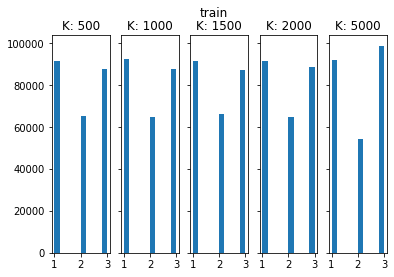

In [30]:
def plot_target_distributions(labels, horizons=[1,2,3,5,10], title="prova"):
  
  fig, axs = plt.subplots(1,len(horizons), sharey=True)
  fig.suptitle(title)
  for i in range(len(horizons)):
    axs[i].hist(labels[:,i])
    axs[i].set_title("K: {}".format(horizons[i]))  
  plt.show()

plot_target_distributions(new_train_labels,Ks,"train")

In [65]:
skip = 1 # time 'ticks' to be skipped
window_size = 5000 # for the rolling mean
m = 2 # std dev

# compute the rolling mean of the mid_prices

#1. create fake temporal data
t = pd.date_range('14/04/1997', periods=mid_prices[maxK:-maxK:skip].shape[0], freq='S')
#2. mix temporal and price data into the same time series
mprice_series = pd.Series(mid_prices[maxK:-maxK:skip], t)

rmean = mprice_series.rolling(window_size).mean().values[window_size:]
ub = rmean + (mprice_series.rolling(window_size).std().values[window_size:] * m)
lb = rmean - (mprice_series.rolling(window_size).std().values[window_size:] * m)

fig = make_subplots(
    rows=1, cols=1)

# plot the mid prices
fig.add_trace(go.Scatter(x=np.arange(mid_prices[::skip].shape[0]), y=mid_prices[::skip], mode='lines', name="mid_prices"),
                row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(window_size, mid_prices[::skip].shape[0]), y=rmean[::skip], mode='lines', name="rmean", line=dict(color="red")),
                row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(window_size, mid_prices[::skip].shape[0]), y=ub[::skip], mode='lines', name="ub", line=dict(color="green")),
                row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(window_size, mid_prices[::skip].shape[0]), y=lb[::skip], mode='lines', name="lb", line=dict(color="orange")),
                row=1, col=1)

# plot the rise+ vertical lines
raise_plus_pos = np.where(new_train_labels[window_size:,-1]==3)[0]
for pos in raise_plus_pos[::600]:
  fig.add_vrect(x0=pos, x1=pos+1, fillcolor="red", opacity=0.25, line_width=1)

# plot the fall+ vertical lines
fall_plus_pos = np.where(new_train_labels[window_size:,-1]==1)[0]
for pos in fall_plus_pos[::600]:
  fig.add_vrect(x0=pos, x1=pos+1, fillcolor="green", opacity=0.25, line_width=3)


fig.show()

Output hidden; open in https://colab.research.google.com to view.

### Save new Train, Val labels
Prepare the train data (input features + new labels) to be saved

In [ ]:
new_train_data = np.concatenate((train_data_copy[maxK:-maxK,:-5], new_train_labels), axis=1)
new_train_data.shape

(254730, 149)

In [ ]:
# split into train and validation
train_slice = slice(0, int(0.8 * new_train_data.shape[0]))
val_slice = slice(int(0.8 * new_train_data.shape[0]), new_train_data.shape[0])


# maintain this order, otherwise new_val_data will be empty
new_val_data = new_train_data[val_slice,:]
new_train_data = new_train_data[train_slice,:]


new_train_data.shape, new_val_data.shape

((203784, 149), (50946, 149))

In [ ]:
# save train, val, test data to file
np.savetxt(datafolder + new_train_file, new_train_data)
np.savetxt(datafolder + new_val_file, new_val_data)

### Save Test labels

Now perform the same operation on *test* data, then save these data on Drive

In [ ]:
test_data_copy = test_data.copy()
test_input_data = test_data_copy[:,:40] # take the features
test_labels = test_data_copy[:,-5:] # take the labels
test_input_data.shape, test_labels.shape

((139587, 40), (139587, 5))

In [ ]:
test_mid_prices = compute_mid_prices(test_input_data)
test_mid_prices.shape

(139587,)

In [ ]:
Ks = [1,2,3,5,10]
maxK = np.max(Ks)

new_test_labels = np.zeros_like(test_labels)

for i, K in enumerate(Ks):
  new_labels = slope_detection_labelling(test_mid_prices, window_shape=K)
  #sns.histplot(new_labels)
  #plt.show()
  
  #print(i, ")", new_labels.shape[0])
  new_test_labels[K-1:-K,i] = new_labels

In [ ]:
new_test_labels = new_test_labels[maxK:-maxK,:]

for i in range(5): # 5 is hardcoded -> it is the # horizons
  #print(np.unique(train_labels[:,-i]), np.unique(new_train_labels[:,-i]) )
  print(Ks[i], count_labels_correspondance(test_labels[maxK:-maxK,-i], new_test_labels[:,-i]), "%")

1 70.67 %
2 37.88 %
3 49.01 %
5 56.64 %
10 62.04 %


In [ ]:
new_test_data = np.concatenate((test_data_copy[maxK:-maxK,:-5], new_test_labels), axis=1)
new_test_data.shape

(139567, 149)

In [ ]:
# save new test data to file
np.savetxt(datafolder + new_test_file, new_test_data)